In [4]:
import pandas as pd
import numpy as np

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [6]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [5]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [7]:
# gerando dados aleatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [8]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [10]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [12]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


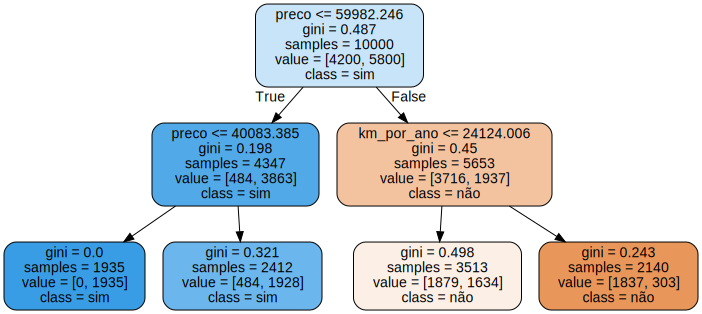

In [16]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                            class_names=['não', 'sim'], 
                            feature_names=features)
graph = graphviz.Source(dot_data)
graph

In [17]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


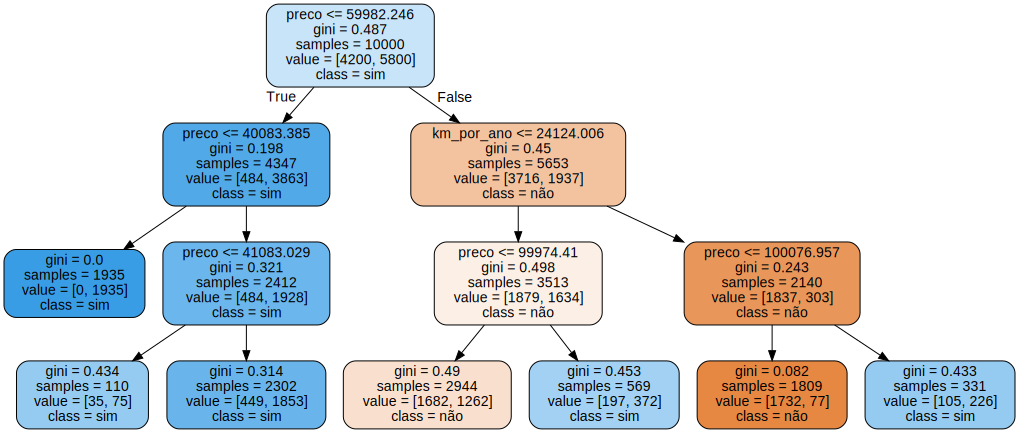

In [18]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                            class_names=['não', 'sim'], 
                            feature_names=features)
graph = graphviz.Source(dot_data)
graph

## Explorando Hiperparâmetros em uma dimensão

In [31]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, treino = %.2f, teste = %.2f," % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
    tabela = [max_depth, train_score, test_score]
    return tabela


#list comprehension
resultados = [roda_arvore_de_decisao(i) for i in range (1,33)]
resultados = pd.DataFrame(resultados, columns=['max_depth', 'train', 'test'])
resultados.head()

Arvore max_depth = 1, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, treino = 78.75, teste = 78.67,
Arvore max_depth = 4, treino = 78.79, teste = 78.63,
Arvore max_depth = 5, treino = 78.94, teste = 78.56,
Arvore max_depth = 6, treino = 79.17, teste = 78.12,
Arvore max_depth = 7, treino = 79.50, teste = 77.96,
Arvore max_depth = 8, treino = 79.89, teste = 77.86,
Arvore max_depth = 9, treino = 80.46, teste = 77.38,
Arvore max_depth = 10, treino = 81.16, teste = 77.19,
Arvore max_depth = 11, treino = 82.03, teste = 76.97,
Arvore max_depth = 12, treino = 82.89, teste = 76.49,
Arvore max_depth = 13, treino = 83.95, teste = 75.81,
Arvore max_depth = 14, treino = 85.03, teste = 75.66,
Arvore max_depth = 15, treino = 86.14, teste = 75.16,
Arvore max_depth = 16, treino = 87.19, teste = 75.11,
Arvore max_depth = 17, treino = 88.31, teste = 74.74,
Arvore max_depth = 18, treino = 89.26, teste = 74.33,
Arvore max_depth = 19, treino = 90.32

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


### Overfit: ficou 'perfeito' para o treino, mas ruim para teste

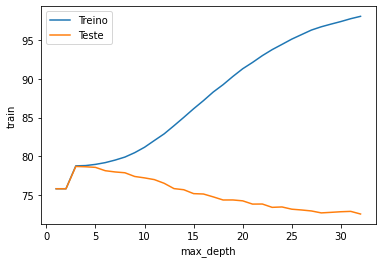

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=resultados, x='max_depth', y='train')
sns.lineplot(data=resultados, x='max_depth', y='test')
plt.legend(['Treino', 'Teste'])

In [35]:
resultados.sort_values('test', ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


## Explorando Hiperparâmetros em duas dimensões

In [51]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

def roda_arvore_de_decisao(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f," % (max_depth, min_samples_leaf, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
    tabela = [max_depth, min_samples_leaf, train_score, test_score]
    return tabela


def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'train', 'test'])
    return resultados

In [43]:
resultados = busca()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67,
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67,
Arvore

In [45]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


In [53]:
corr = resultados.corr()

<AxesSubplot:>

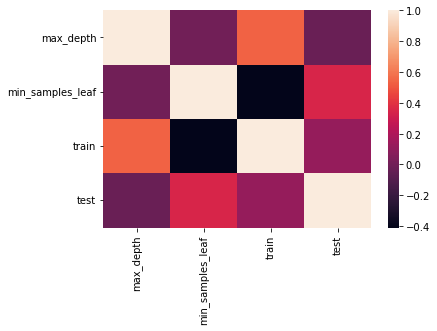

In [54]:
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train'>,
        <AxesSubplot:xlabel='train', ylabel='train'>,
        <AxesSubplot:xlabel='test', ylabel='train'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test'>,
        <AxesSubplot:xlabel='train', ylabel='test'>,
        <AxesSubplot:xlabel='test', ylabel='test'>]], dtype=object)

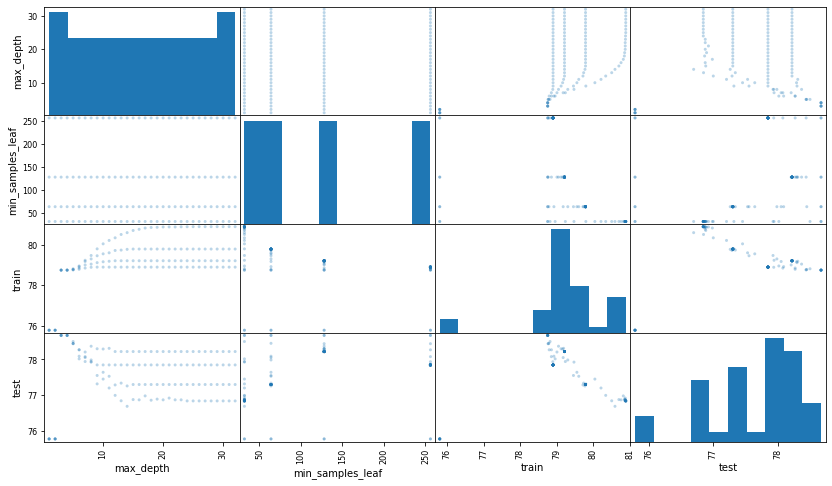

In [56]:
pd.plotting.scatter_matrix(resultados, figsize = (14,8), alpha = 0.3)

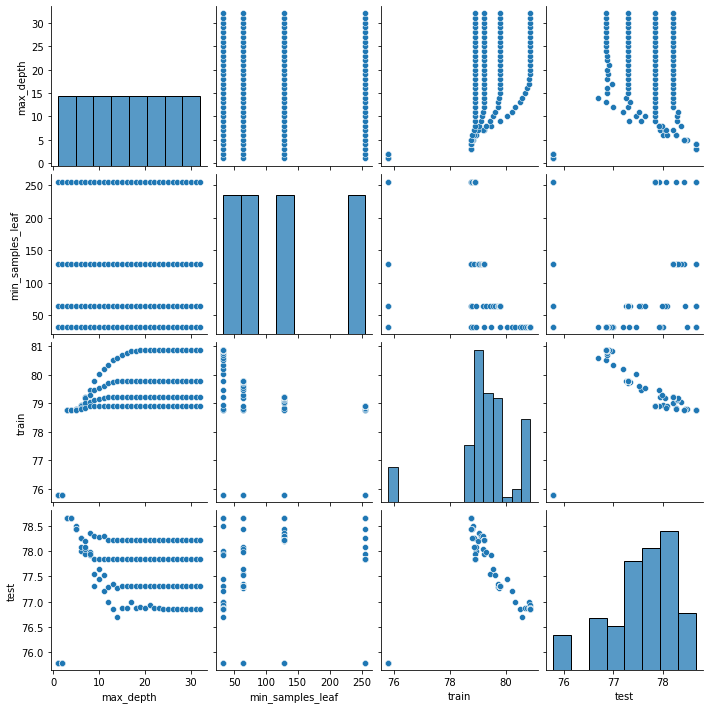

In [57]:
sns.pairplot(resultados)

/tmp/ipykernel_27189/1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

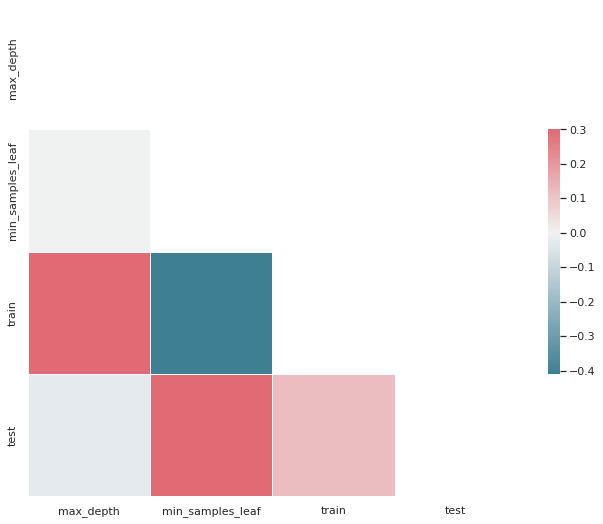

In [58]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [59]:
def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [128, 192, 256, 512]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'train', 'test'])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.50,
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67,

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


In [60]:
corr = resultados.corr()

/tmp/ipykernel_27189/1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

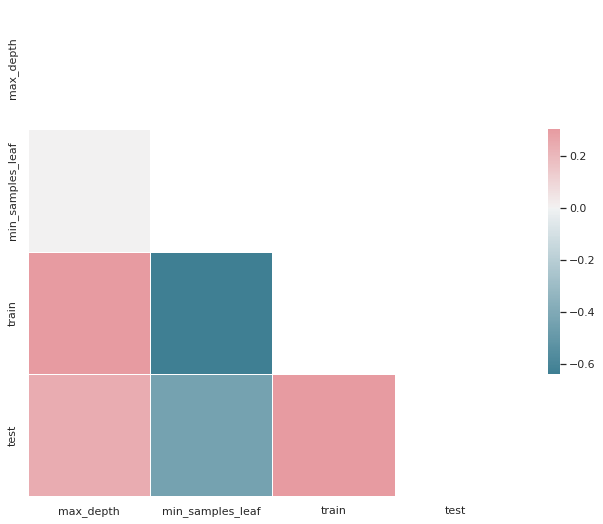

In [61]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [62]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


## Explorando Hiperparâmetros com três dimensões

In [69]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
    return tabela


def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'min_samples_split', 'train', 'test', 'fit_time', 'score_time'])
    return resultados

In [70]:
resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.004317,0.001573
1,1,32,64,75.791169,75.784219,0.004202,0.001310
2,1,32,128,75.791169,75.784219,0.003951,0.001398
3,1,32,256,75.791169,75.784219,0.003851,0.001357
4,1,64,32,75.791169,75.784219,0.003930,0.001326


/tmp/ipykernel_27189/1709128675.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

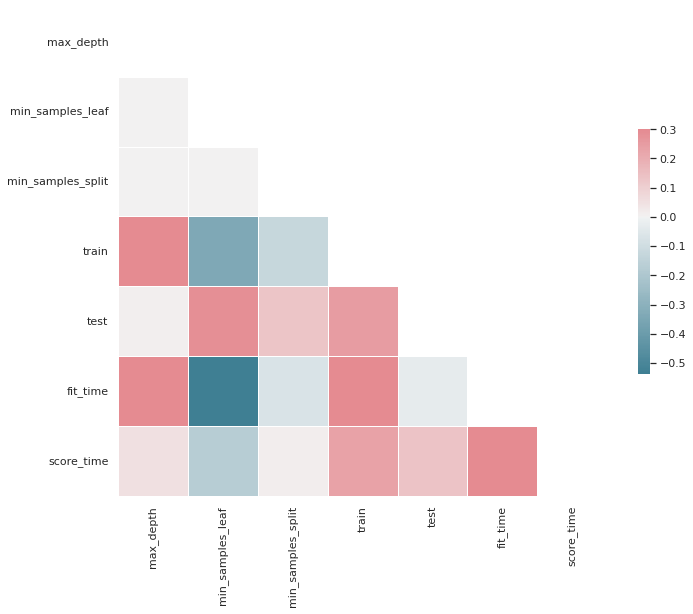

In [71]:
corr = resultados.corr()
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [72]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.008076,0.001403
48,4,32,32,78.750993,78.672633,0.008691,0.001419
34,3,32,128,78.750993,78.672633,0.007151,0.001534
35,3,32,256,78.750993,78.672633,0.007110,0.001355
36,3,64,32,78.750993,78.672633,0.007490,0.001457


## Utilizando Grid Search CV

In [73]:
from sklearn.model_selection import GridSearchCV

In [74]:
SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_parametros,
                    cv = GroupKFold(n_splits=10))

busca.fit(x_azar, y_azar, groups=dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007538,0.000906,0.001425,0.000245,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.007196,0.000368,0.001328,0.000123,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.008113,0.001103,0.001713,0.000540,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.007454,0.000747,0.001451,0.000249,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.006945,0.000155,0.001240,0.000100,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [77]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [79]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [85]:
from sklearn.metrics import accuracy_score

# evitar essa abordagem pois estará sendo otimista
predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar) * 100
print("Accuracy para os dados foi %.2f" % accuracy)

Accuracy para os dados foi 78.75


## Como ter uma estimativa sem esse vício nos dados que eu já vi?
No caso de CV com busca de hiperparametros, fazemos uma nova validação cruzada. Chama-se nested cross validation

In [86]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

# Infelizmente como o Pandas não suporta nested validation com group K fold, não conseguimos prever o resutlado para novos grupos

/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py", lin

In [87]:
from sklearn.model_selection import KFold
SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_parametros,
                    cv = KFold(n_splits=5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013596,0.012972,0.002005,0.001062,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.006788,0.000384,0.001660,0.000327,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.006959,0.000386,0.001493,0.000359,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.006662,0.000289,0.001583,0.000142,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.006868,0.000455,0.001502,0.000123,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [89]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7795, 0.7905, 0.786 , 0.791 , 0.788 ])

In [90]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [91]:
imprime_score(scores)

Accuracy médio 78.70
Intervalo [77.87, 79.53]


In [92]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

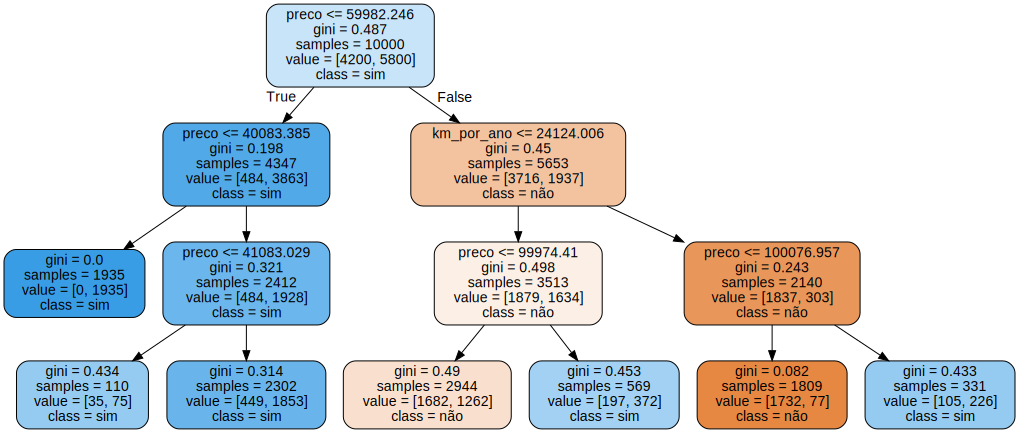

In [93]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True, 
                            class_names=['não', 'sim'], 
                            feature_names=features)
graph = graphviz.Source(dot_data)
graph